**CNNによる2次元顔画像表情判定**

In [1]:
!ps aux
!kill -9 <pid>

USER         PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
root           1  0.2  0.0    992     4 ?        Ss   14:06   0:00 /sbin/docker-
root           7  0.2  0.3 337252 47692 ?        Sl   14:06   0:00 /tools/node/b
root          17  0.2  0.0  35892  4896 ?        Ss   14:06   0:00 tail -n +0 -F
root          40  0.1  0.3 160356 41888 ?        S    14:06   0:00 python3 /usr/
root          53  0.5  0.4 193892 59980 ?        Sl   14:06   0:01 /usr/bin/pyth
root          54  0.0  0.0 706824  4844 ?        Sl   14:06   0:00 /usr/local/bi
root          65 20.4  0.8 689464 115116 ?       Ssl  14:10   0:02 /usr/bin/pyth
root          85  0.3  0.1  93576 14208 ?        Sl   14:10   0:00 /usr/bin/pyth
root         102  0.0  0.0  59040  6412 ?        R    14:10   0:00 ps aux
/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `kill -9 <pid>'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,MaxPooling2D,Conv2D
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

**訓練画像、検証画像、テスト画像のディレクトリ**

In [4]:
classes = ['angry', 'disgust','fear','happy','neutral','sad','suprise']
nb_classes = len(classes)
batch_size_for_data_generator = 20

base_dir = '/content/drive/MyDrive/kaggle/Facial Experience'

train_dir = base_dir+'/train'
validation_dir = base_dir+'/valid'
test_dir = base_dir+'/test'

img_rows, img_cols = 48, 48

os.path.join(base_dir,'path')

**ImageDataGeneratorを使って画像データを拡張する**

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(img_rows, img_cols),
                                                    color_mode='rgb',
                                                    classes=classes,
                                                    class_mode='categorical',
                                                    batch_size=1117,
                                                    shuffle=True)

Found 84892 images belonging to 7 classes.


train 84892枚
2x2x19x1117
バッジサイズ2048

In [9]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = test_datagen.flow_from_directory(directory=validation_dir,
                                                        target_size=(img_rows, img_cols),
                                                        color_mode='rgb',
                                                        classes=classes,
                                                        class_mode='categorical',
                                                        batch_size=131,
                                                        shuffle=True)

Found 21615 images belonging to 7 classes.


valid 21615枚 3x5x11x131 バッジサイズ2048

**CNNモデル**

なんで512?→特に理由なし1024でもなんでもいい

dropoutの役割→層から層への伝達の際に出力データを意図的に0とする事で、訓練データに過剰適合する問題を回避する。

出力層
二値分類→sigmoid
他クラス分類→softmax
回帰分類→恒等関数

モデル参照先
https://sciresol.s3.us-east-2.amazonaws.com/IJST/Articles/2019/Issue-24/Article9.pdf

leaky relu

relu関数においてx<0のとき正の傾きを与える

In [10]:
model=Sequential()
# 畳み込み層
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(img_rows, img_cols, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Dropout(0.2))

# 全結合層
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

# 出力層
model.add(Dense(nb_classes, activation='softmax'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

In [11]:
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer= opt, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**コールバックを使った学習**

In [21]:
hdf5_file = os.path.join(base_dir, 'model.hdf5')

再度ここから

In [37]:
from keras.callbacks import ModelCheckpoint
modelCheckpoint = ModelCheckpoint(filepath = hdf5_file,
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

In [38]:
history = model.fit(train_generator,
                    steps_per_epoch=76,
                    epochs=5,
                    validation_data=validation_generator,
                    validation_steps=165,
                    callbacks=[modelCheckpoint],
                    verbose=1)

Epoch 1/5
76/76 [==============================] - 442s 6s/step - loss: 0.9481 - acc: 0.6549 - val_loss: 1.2095 - val_acc: 0.5390

Epoch 00001: val_loss improved from inf to 1.20946, saving model to /content/drive/MyDrive/kaggle/Facial Experience/model.hdf5
Epoch 2/5
76/76 [==============================] - 437s 6s/step - loss: 0.9367 - acc: 0.6600 - val_loss: 1.2022 - val_acc: 0.5462

Epoch 00002: val_loss improved from 1.20946 to 1.20215, saving model to /content/drive/MyDrive/kaggle/Facial Experience/model.hdf5
Epoch 3/5
76/76 [==============================] - 434s 6s/step - loss: 0.9239 - acc: 0.6637 - val_loss: 1.2117 - val_acc: 0.5433

Epoch 00003: val_loss did not improve from 1.20215
Epoch 4/5
76/76 [==============================] - 432s 6s/step - loss: 0.9200 - acc: 0.6650 - val_loss: 1.2743 - val_acc: 0.5193

Epoch 00004: val_loss did not improve from 1.20215
Epoch 5/5
76/76 [==============================] - 431s 6s/step - loss: 0.9085 - acc: 0.6683 - val_loss: 1.2370 - va

In [39]:
model.save(hdf5_file)

In [40]:
import matplotlib.pyplot as plt

In [41]:
%matplotlib inline

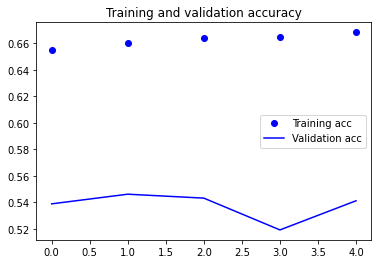

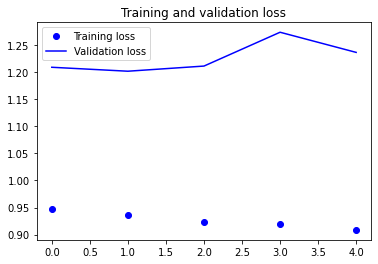

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
# test_generator = test_datagen.flow_from_directory(directory=test_dir,
#                                                   target_size=(img_rows, img_cols),
#                                                   color_mode='rgb',
#                                                   classes=classes,
#                                                   class_mode='categorical',
#                                                   batch_size=batch_size_for_data_generator)

# test_loss, test_acc = model.evaluate(test_generator, steps=50)
# print('test acc:', test_acc)

In [44]:
# predictions = model.predict_generator(test_generator, steps=50)
# # Get most likely class
# predicted_classes = numpy.argmax(predictions, axis=1)
# # Ground-Truthクラスとクラスラベルを取得する
# true_classes = test_generator.classes
# class_labels = list(test_generator.class_indices.keys())
# # scikit-learnを使用して統計を取得する
# report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
# print(report)

**参考**


*   [Keras / CNN] 多クラス画像分類 --- ラーメンの味分類

    https://qiita.com/Phoeboooo/items/cfe8560fe8a285855340
*   リスト項目

